In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakes-data/FA-KES-Dataset.csv
/kaggle/input/fakes-data/glove.6B.100d.txt


In [23]:
import matplotlib.pyplot as plt
import re
import math
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

In [24]:
df = pd.read_csv('/kaggle/input/fakes-data/FA-KES-Dataset.csv', encoding = "latin-1")

In [25]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,unit_id,article_title,article_content,source,date,location,labels,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,04-05-2017,idlib,0,NaN,NaN,NaN,NaN
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,04-07-2017,homs,0,NaN,NaN,NaN,NaN
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,NaN,NaN,NaN,NaN
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,NaN,NaN,NaN,NaN
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,07-10-2016,aleppo,0,NaN,NaN,NaN,NaN


In [26]:
# Use only the article_content as done in the paper
df['article_content'] = df['article_content'].fillna('')

# Download required NLTK data
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Define the cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the cleaning function to the article content
df['article_content'] = df['article_content'].apply(clean_text)

# Extract features and labels
X = df['article_content'].astype(str)
y = df['labels']

In [28]:
# ---- 2. Train-Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
results = []

In [30]:
# ---- 3. Traditional ML Models ----
models = {
    'LR': LogisticRegression(class_weight='balanced', max_iter=100),
    'RF': RandomForestClassifier(n_estimators=100),
    'MNB': MultinomialNB(),
    'SGD': SGDClassifier(),
    'KNNs': KNeighborsClassifier(n_neighbors=5),
    'DT': DecisionTreeClassifier(),
    'AB': AdaBoostClassifier()
}

roc_data = []

for name, model in models.items():
    clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', model)])
    clf.fit(X_train, y_train)
    if hasattr(clf.named_steps['clf'], "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    else:
        y_scores = clf.decision_function(X_test)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    auc = roc_auc_score(y_test, y_scores)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_data.append((name, fpr, tpr, auc))
    results.append((name, acc, precision, recall, f1))

In [31]:
# ---- 4. Load Pre-trained GloVe Embeddings ----
glove_path = '/kaggle/input/fakes-data/glove.6B.100d.txt'

# Initialize an empty dictionary to store the word vectors
embedding_index = {}

# Read the GloVe file line by line
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Split the line into word and vector components
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"✅ Loaded {len(embedding_index):,} word vectors from GloVe (100d).")

✅ Loaded 400,000 word vectors from GloVe (100d).


In [32]:
# ---- 4. Tokenization for Deep Learning ----
MAX_NUM_WORDS = 400000
MAX_SEQUENCE_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))  # vocab_size = tokenizer.num_words or len(tokenizer.word_index) + 1

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [33]:
from keras import backend as K

# Clear Keras session to release memory after training a model
def clear_keras_session():
    K.clear_session()

In [34]:
def convert_to_embedding_tensor(X_pad, embedding_matrix):
    return np.array([[embedding_matrix[idx] if idx < len(embedding_matrix) else np.zeros(100)
                      for idx in sentence] for sentence in X_pad])

X_train_vec = convert_to_embedding_tensor(X_train_pad, embedding_matrix)
X_test_vec = convert_to_embedding_tensor(X_test_pad, embedding_matrix)

In [35]:
# ---- 6.1 CNN Only (without embedding)----
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn.fit(X_train_vec, y_train, batch_size=64, epochs=10, verbose=1)

cnn_preds = (cnn.predict(X_test_vec) > 0.5).astype(int)

results.append(('CNN only (no embedding)', accuracy_score(y_test, cnn_preds),
                precision_score(y_test, cnn_preds),
                recall_score(y_test, cnn_preds),
                f1_score(y_test, cnn_preds)))

y_scores = cnn.predict(X_test_vec).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
roc_data.append(("CNN only (no embedding)", fpr, tpr, auc))

clear_keras_session()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4940 - loss: 0.8446
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5736 - loss: 0.6409
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7499 - loss: 0.5445
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8815 - loss: 0.4377
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9352 - loss: 0.3704
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9407 - loss: 0.3180
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9684 - loss: 0.2695
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9809 - loss: 0.2156
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - loss: 0.1761
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.1582
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [36]:
# ---- 6.2 CNN Only  (with embedding)----
cnn = Sequential()
cnn.add(Embedding(input_dim=vocab_size,
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  trainable=True))
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn.fit(X_train_pad, y_train, batch_size=64, epochs=10, verbose=1)
cnn_preds = cnn.predict(X_test_pad) > 0.5
results.append(('CNN only (with embedding)', 
                accuracy_score(y_test, cnn_preds), 
                precision_score(y_test, cnn_preds), 
                recall_score(y_test, cnn_preds), 
                f1_score(y_test, cnn_preds)))

y_scores = cnn.predict(X_test_pad).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
roc_data.append(("CNN only (with embedding)", fpr, tpr, auc))

clear_keras_session()

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5073 - loss: 0.8174
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7250 - loss: 0.5588
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8648 - loss: 0.4819
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8896 - loss: 0.4036 
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9509 - loss: 0.3410 
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9506 - loss: 0.2648 
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9652 - loss: 0.2409 
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9603 - loss: 0.2003 
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.1521 
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9836 - loss: 0.1335
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [37]:
#---- 7. RNN Only (LSTM) (without embedding)----
rnn = Sequential()
rnn.add(LSTM(units=32, return_sequences=False, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
rnn.fit(X_train_vec, y_train, batch_size=64, epochs=10, verbose=1)

rnn_preds = (rnn.predict(X_test_vec) > 0.5).astype(int)

results.append(('RNN only (no embedding)', 
                accuracy_score(y_test, rnn_preds), 
                precision_score(y_test, rnn_preds), 
                recall_score(y_test, rnn_preds), 
                f1_score(y_test, rnn_preds)))

y_scores = rnn.predict(X_test_vec).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
roc_data.append(("RNN only (no embedding)", fpr, tpr, auc))

clear_keras_session()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5053 - loss: 0.6931
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5257 - loss: 0.6872
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5369 - loss: 0.6885
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5481 - loss: 0.6842
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5342 - loss: 0.6829
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5509 - loss: 0.6836
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5464 - loss: 0.6806
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5865 - loss: 0.6751
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5490 - loss: 0.6754
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5453 - loss: 0.6685
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [38]:
#---- 7. RNN Only (LSTM) (with embedding)----
rnn = Sequential()
rnn.add(Embedding(input_dim=vocab_size,
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=X_train_pad.shape[1],
                  trainable=True))
rnn.add(LSTM(units=32, return_sequences=False))

rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
rnn.fit(X_train_pad, y_train, batch_size=64, epochs=10, verbose=1)
rnn_preds = rnn.predict(X_test_pad) > 0.5
results.append(('RNN only (with embedding)', 
                accuracy_score(y_test, rnn_preds), 
                precision_score(y_test, rnn_preds), 
                recall_score(y_test, rnn_preds), 
                f1_score(y_test, rnn_preds)))

y_scores = rnn.predict(X_test_pad).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
roc_data.append(("RNN only (with embedding)", fpr, tpr, auc))

clear_keras_session()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4852 - loss: 0.6962
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5433 - loss: 0.6871
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5190 - loss: 0.6866
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5735 - loss: 0.6800
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5587 - loss: 0.6769
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5543 - loss: 0.6721
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5471 - loss: 0.6681
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5730 - loss: 0.6560
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5722 - loss: 0.6426
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5718 - loss: 0.6332
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [39]:
# ---- 8. CNN + RNN Hybrid ----
hybrid = Sequential()
hybrid.add(Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=X_train_pad.shape[1],
                     trainable=True))

# Reduce filters and kernel size
hybrid.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=2))

hybrid.add(LSTM(units=32, return_sequences=False))

hybrid.add(Dense(1, activation='sigmoid'))

hybrid.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Add validation_split to monitor performance
history = hybrid.fit(X_train_pad, y_train, batch_size=64, epochs=10, verbose=1)

hybrid_preds = hybrid.predict(X_test_pad) > 0.5
results.append(('CNN+RNN Hybrid', 
                accuracy_score(y_test, hybrid_preds), 
                precision_score(y_test, hybrid_preds), 
                recall_score(y_test, hybrid_preds), 
                f1_score(y_test, hybrid_preds)))

y_scores = hybrid.predict(X_test_pad).ravel()
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
roc_data.append(("Hybrid", fpr, tpr, auc))

clear_keras_session()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4931 - loss: 0.6977
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5424 - loss: 0.6822
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5660 - loss: 0.6711
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5480 - loss: 0.6641
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5644 - loss: 0.6467
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5797 - loss: 0.6373
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5866 - loss: 0.6197
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5752 - loss: 0.6152
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5825 - loss: 0.6095
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5902 - loss: 0.6023
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [40]:
# ---- 9. Show Results ----
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(df_results)

                        Model  Accuracy  Precision    Recall  F1-Score
0                          LR  0.540373   0.586207  0.573034  0.579545
1                          RF  0.590062   0.616162  0.685393  0.648936
2                         MNB  0.534161   0.550000  0.865169  0.672489
3                         SGD  0.552795   0.585859  0.651685  0.617021
4                        KNNs  0.546584   0.593023  0.573034  0.582857
5                          DT  0.509317   0.565789  0.483146  0.521212
6                          AB  0.590062   0.641975  0.584270  0.611765
7     CNN only (no embedding)  0.540373   0.570093  0.685393  0.622449
8   CNN only (with embedding)  0.540373   0.554745  0.853933  0.672566
9     RNN only (no embedding)  0.559006   0.558442  0.966292  0.707819
10  RNN only (with embedding)  0.465839   0.636364  0.078652  0.140000
11             CNN+RNN Hybrid  0.565217   0.563758  0.943820  0.705882


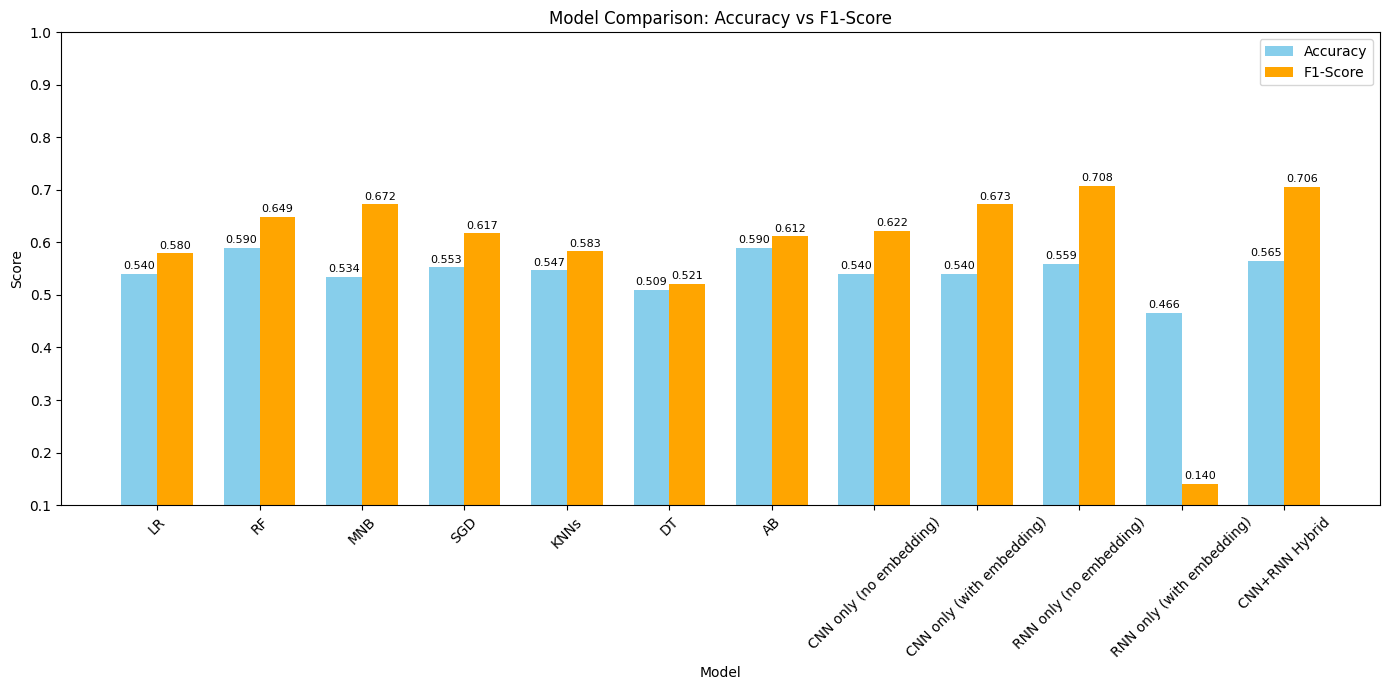

In [41]:
# Set the figure size
plt.figure(figsize=(14, 7))

# Bar width
bar_width = 0.35
index = np.arange(len(df_results))

# Plot Accuracy and F1-Score bars
plt.bar(index, df_results['Accuracy'], bar_width, label='Accuracy', color='skyblue')
plt.bar(index + bar_width, df_results['F1-Score'], bar_width, label='F1-Score', color='orange')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs F1-Score')
plt.xticks(index + bar_width / 2, df_results['Model'], rotation=45)
plt.ylim(0.1, 1.0)
plt.legend()

# Add value labels on bars
for i in range(len(df_results)):
    plt.text(i, df_results['Accuracy'][i] + 0.005, f"{df_results['Accuracy'][i]:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(i + bar_width, df_results['F1-Score'][i] + 0.005, f"{df_results['F1-Score'][i]:.3f}", ha='center', va='bottom', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


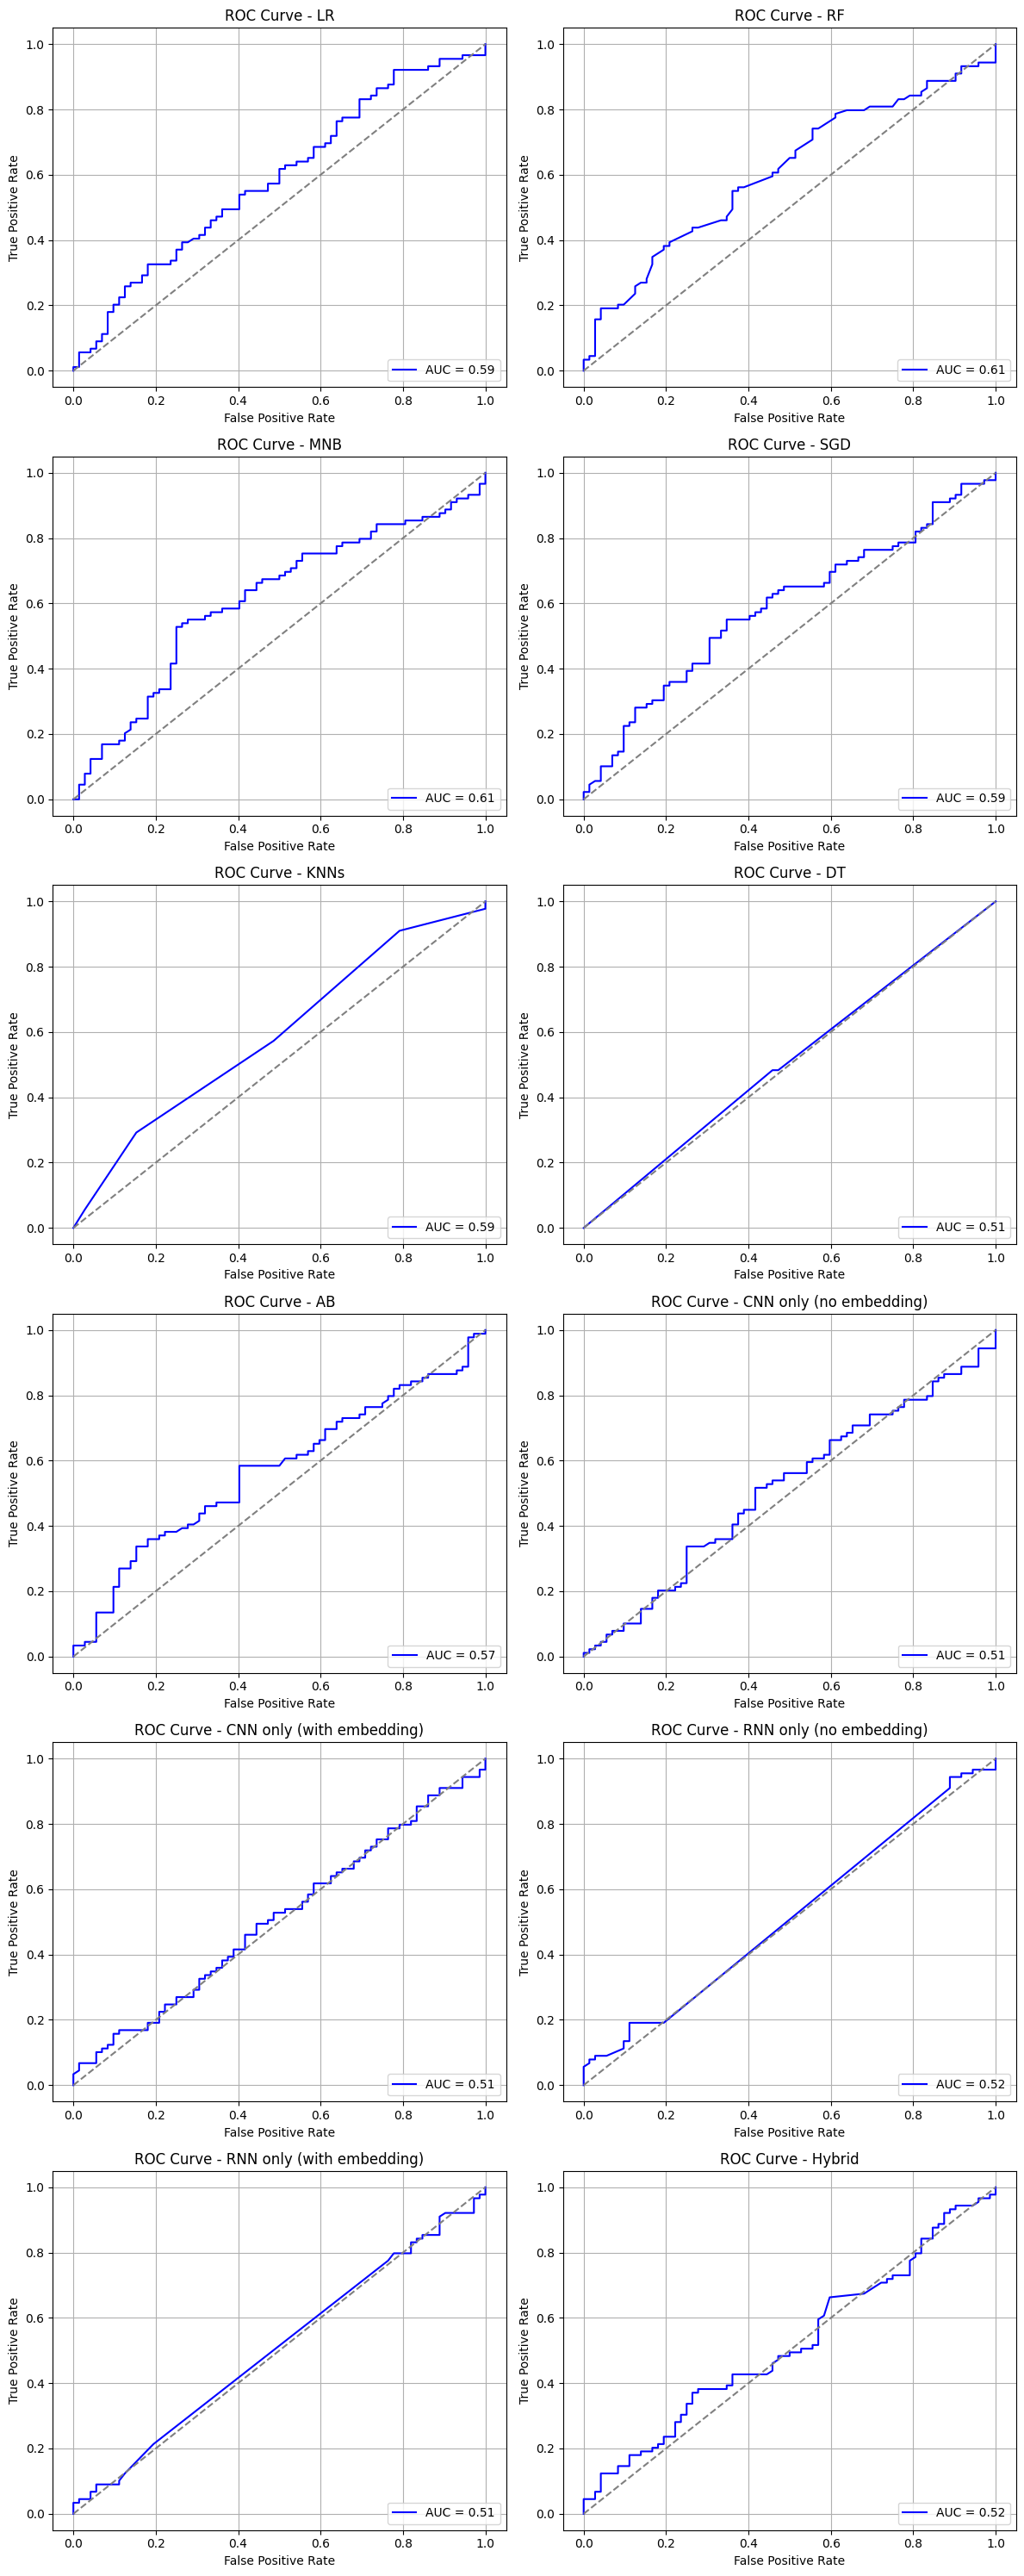

In [43]:
import matplotlib.pyplot as plt
import math

# Number of models
n_models = len(roc_data)

# Compute number of rows (2 plots per row)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))

# Flatten axes array for easy indexing
axes = axes.flatten()

for idx, (name, fpr, tpr, auc) in enumerate(roc_data):
    ax = axes[idx]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title(f"ROC Curve - {name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()